In [1]:
%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import numpy as np
import cupy as cp
import copy
kgs.set_float32(True)

local


In [2]:
%load_ext pyinstrument

In [3]:
#%%pyinstrument
import pack_io
importlib.reload(pack_io)
import pandas as pd
theirs_raw = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.code_dir + '../res/70.74.csv'))
# Recompute scores using h²/N for consistency with other sources
theirs = (theirs_raw[0], [(s.h[0,0]**2/s.N_trees).get() for s in theirs_raw[0]])

In [4]:
# import matplotlib.pyplot as plt
# N_trees = np.arange(1,201)
# x1 = np.sqrt(N_trees)
# y1 = theirs[1]*N_trees / x1
# coeff1 = np.polyfit(x1, y1, 1)
# plt.figure()
# plt.plot(x1, y1, label='Scaled Score')
# plt.plot(x1, coeff1[0]*x1 + coeff1[1], '--', label=f'Linear fit: y={coeff1[0]:.3f}x+{coeff1[1]:.3f}')
# plt.legend()

# y2 = theirs[1]*N_trees
# coeff2 = np.polyfit(N_trees, y2, 1)
# plt.figure()
# plt.plot(N_trees, y2, label='Raw Score')
# plt.plot(N_trees, coeff2[0]*N_trees + coeff2[1], '--', label=f'Linear fit: y={coeff2[0]:.3f}x+{coeff2[1]:.3f}')
# plt.legend()

# plt.figure()
# x3 = 1/np.sqrt(N_trees)
# y3 = theirs[1]
# coeff3 = np.polyfit(x3[10:40], y3[10:40], 1)
# plt.plot(x3, y3, label='Inverse Sqrt Scaled Score')
# plt.plot(x3, coeff3[0]*x3 + coeff3[1], '--', label=f'Linear fit: y={coeff3[0]:.3f}x+{coeff3[1]:.3f}')
# plt.legend()
# 1/0.15**2

In [5]:
import glob
from tqdm import tqdm
mine_list = [kgs.code_dir + '../res/tess_legalized.pickle'] + glob.glob(kgs.code_dir + '../res/ga_*.pickle')
print('remove all but tess later')
print(mine_list)
mine_list = [kgs.dill_load(x) for x in mine_list]

mine_list.append(pack_io.dataframe_to_solution_list(pd.read_csv(kgs.code_dir + '../res/my_old_with_85.csv'))[0])

import glob
sols_controller = []
for N_trees in tqdm(np.arange(1,201)):    
    gl=glob.glob(kgs.temp_dir + f'/*runs/done/ga_N{N_trees}_*.pickle') + glob.glob(kgs.temp_dir + f'/*runs/extra/ga_N{N_trees}_*.pickle') + glob.glob(kgs.temp_dir + f'/*runs/repro/ga_N{N_trees}_*.pickle') + \
        glob.glob(kgs.temp_dir + f'/rerun_done/done/ga_N{N_trees}_*.pickle')
    if len(gl)>0:
        best_res = None
        best_score = np.inf
        for g in gl:
            #print(g)
            rr = kgs.dill_load(g)
            score = (rr.ga.champions[0].phenotype.h[0,0]**2 / rr.ga.champions[0].phenotype.N_trees).get()
            if score < best_score:
                best_score = score
                best_res = rr
        sols_controller.append(best_res.ga.champions[0].phenotype)
        #sols_controller.append(rr.ga.champions[0].phenotype)
        #res_per_tree[N_trees].append([x[0] for x in rr.ga.best_costs_per_generation[-1]])
        #print(N_trees)
mine_list.append(sols_controller)
for m in mine_list:
    for s in m:
        s.xyt = s.xyt.astype(kgs.dtype_cp)
        s.h = s.h.astype(kgs.dtype_cp)
mine = []
for N_trees in np.arange(1,201):
    best_score = np.inf
    for m in mine_list:
        for s in m:
            if s.N_trees == N_trees:
                score = (s.h[0,0]**2/s.N_trees).get()
                if score < best_score:
                    best_score = score
                    best_sol = s
    mine.append(best_sol)
score = [(x.h[0,0]**2/x.N_trees).get() for x in mine]
mine = (mine,score)
kgs.dill_save(kgs.code_dir + '../res/mine.pickle', mine)

remove all but tess later
['/mnt/d//packing/code/core/../res/tess_legalized.pickle', '/mnt/d//packing/code/core/../res/ga_1to10.pickle', '/mnt/d//packing/code/core/../res/ga_36_to_36.pickle', '/mnt/d//packing/code/core/../res/ga_multi_tree_11_to_25.pickle', '/mnt/d//packing/code/core/../res/ga_multi_tree_11_to_25_cont.pickle', '/mnt/d//packing/code/core/../res/ga_multi_tree_26_to_29.pickle', '/mnt/d//packing/code/core/../res/ga_multi_tree_30_to_30.pickle', '/mnt/d//packing/code/core/../res/ga_multi_tree_40_to_40.pickle']


100%|██████████| 200/200 [05:26<00:00,  1.63s/it]


In [6]:
x=pack_io.dataframe_to_solution_list(pd.read_csv(kgs.code_dir + '../res/my_old_with_85.csv'))


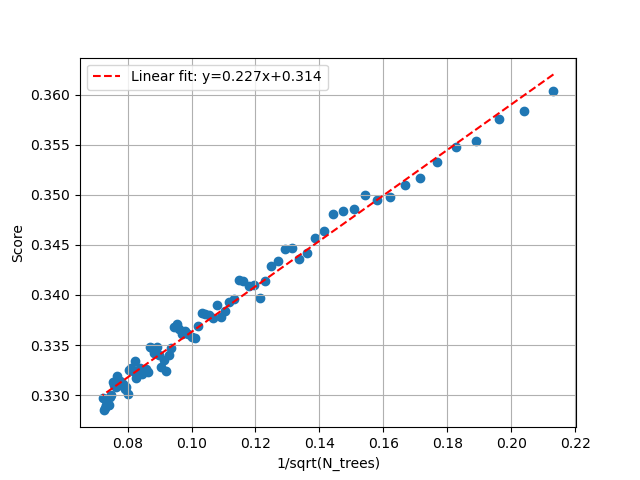

In [7]:
import mplcursors
import matplotlib.pyplot as plt

N_trees = np.arange(1,201)
plt.figure()
N1=21
N2=193
plt.scatter(1/np.sqrt(N_trees[N1:N2:2]), mine[1][N1:N2:2])
plt.grid(True)
plt.xlabel('1/sqrt(N_trees)')
plt.ylabel('Score')
# add a linear fit to the line; store the coefficients as well for later use
x_fit = 1/np.sqrt(N_trees[N1:N2:2])
y_fit = mine[1][N1:N2:2]
coeffs = np.polyfit(x_fit, y_fit, 1)
plt.plot(x_fit, coeffs[0]*x_fit + coeffs[1], '--r', label=f'Linear fit: y={coeffs[0]:.3f}x+{coeffs[1]:.3f}')
plt.legend()
prognosis = coeffs[0]/np.sqrt(N_trees) + coeffs[1]
pred_odd = np.array(mine[1].copy())
pred_odd[2::2] = pred_odd[1:-2:2]/2+pred_odd[3::2]/2+0.001
#pred_odd[2::2] = np.minimum(pred_odd[2::2], mine[1][2::2])

(np.float64(70.74654623328446),
 np.float32(68.84306),
 np.float64(68.8355204870682),
 np.float64(68.8292356305939))

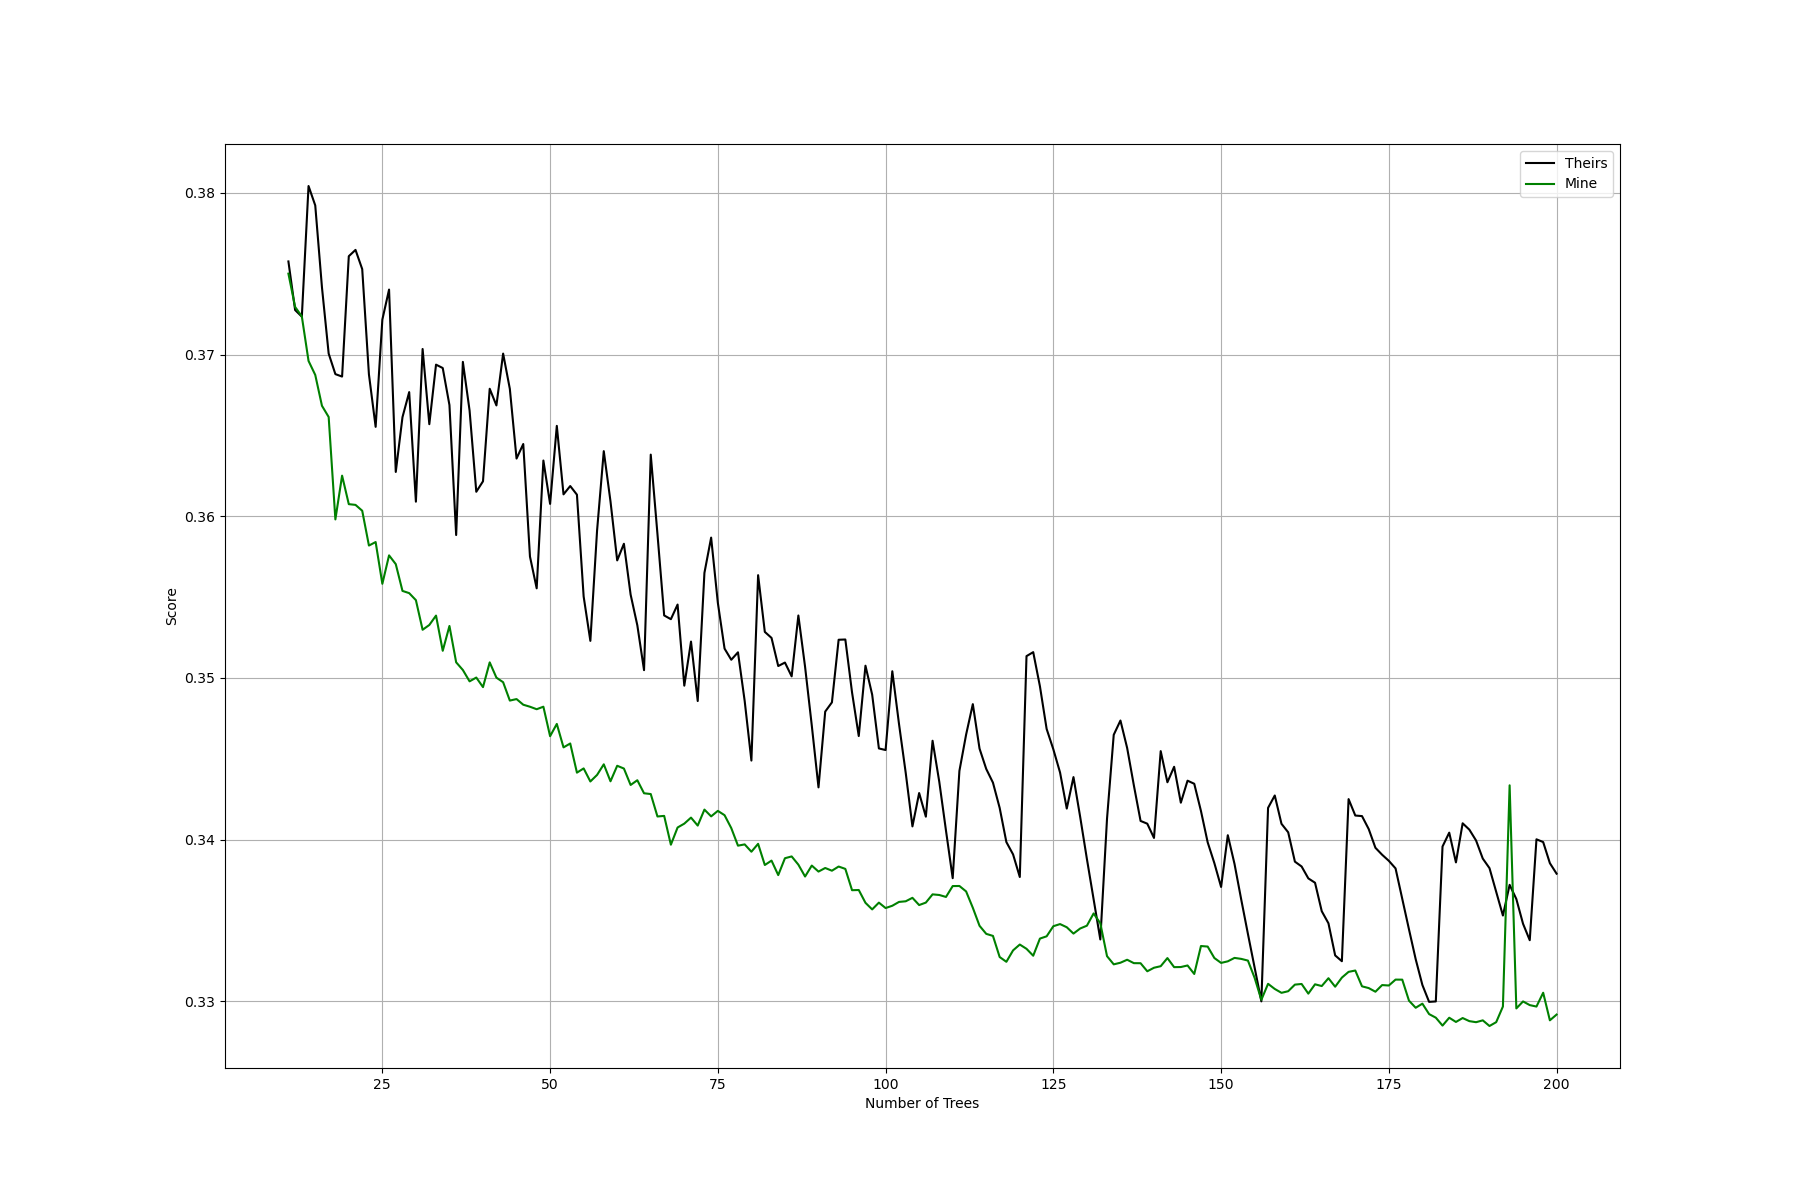

In [8]:
plt.figure(figsize=(18,12))
N=10
lines = []
vals_res = np.array([np.inf]*200)
line = plt.plot(N_trees[N:], theirs[1][N:], 'k')
lines.extend(line)
line = plt.plot(N_trees[N:], mine[1][N:], 'g')
lines.extend(line)
#line = plt.plot(N_trees[N:], prognosis[N:], 'r--')
#lines.extend(line)
#line = plt.plot(N_trees[N:], pred_odd[N:], 'b')
#lines.extend(line)


#dat = pd.read_csv('/mnt/d/packing/data/table_data.csv')
#line = plt.plot(dat['n'], dat['score'], 'b')

plt.grid(True)
plt.legend(('Theirs', 'Mine', 'Prognosis'))
plt.xlabel('Number of Trees')
plt.ylabel('Score')

# Add interactive cursor for all lines
mplcursors.cursor(lines, hover=True)
NN=108
np.sum(theirs[1]), np.sum(mine[1]), np.sum(np.minimum(theirs[1], mine[1])), np.sum(mine[1][:NN]) + np.sum(np.minimum(theirs[1],np.minimum(mine[1],pred_odd))[NN:])#, np.sum(mine[1][:NN]) + np.sum((prognosis[NN:])), np.sum(mine[1][:NN]) + np.sum(np.minimum(mine[1][NN:], prognosis[NN:]))

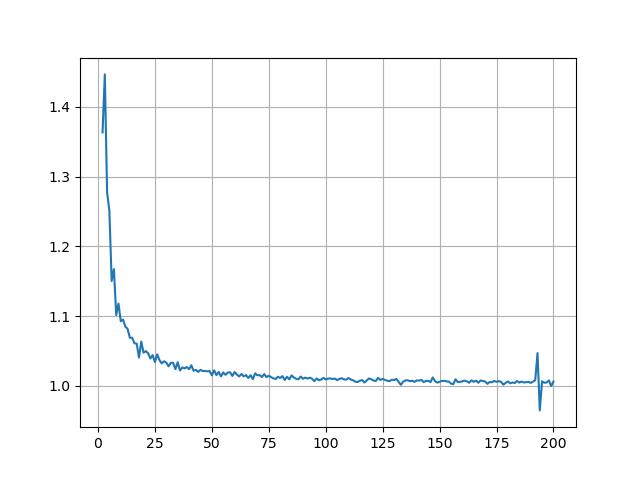

In [9]:
plt.figure()
area = mine[1]*N_trees
plt.plot(N_trees[1:], np.array(area[1:])/area[:-1])
plt.grid(True)

init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 22.049 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 3.293 ms
ptx

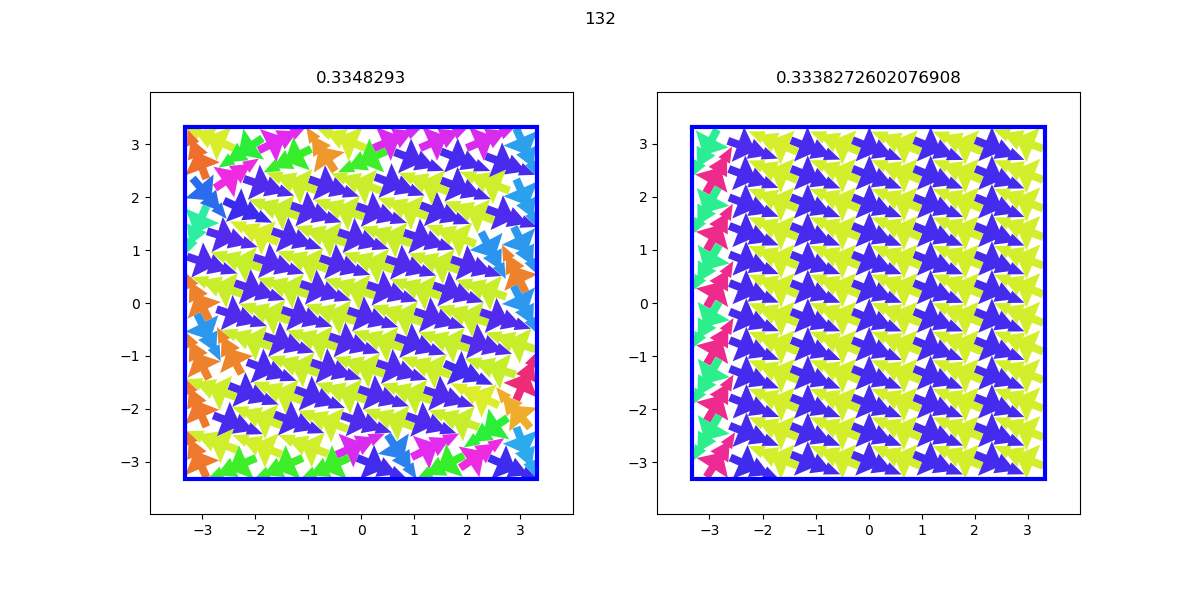

In [10]:
#importlib.reload(kgs)
for N in [132]:
    _,ax = plt.subplots(1,2,figsize=(12,6))
    pack_vis_sol.pack_vis_sol(mine[0][N-1], solution_idx=0, ax=ax[0])
    plt.sca(ax[0])
    plt.title(mine[1][N-1])
    sol2 = copy.deepcopy(theirs[0][N-1])
    sol2.xyt[0,...] = kgs.find_best_transformation(mine[0][N-1].xyt[0], sol2.xyt[0])[0]
    sol2.snap()
    #sol2.xyt = cp.concatenate((overall_best[N-1].xyt, sol2.xyt), axis=1)
    pack_vis_sol.pack_vis_sol(sol2, solution_idx=0, ax=ax[1])
    plt.sca(ax[1])
    plt.title(theirs[1][N-1])
    plt.suptitle(N)

Score of generated dataframe: 68.82872178368478
Combined total score: 68.829541
Mine total score: 68.843063
Theirs total score: 70.746546
Initial best total score: 68.835520
Improvement: 0.005979


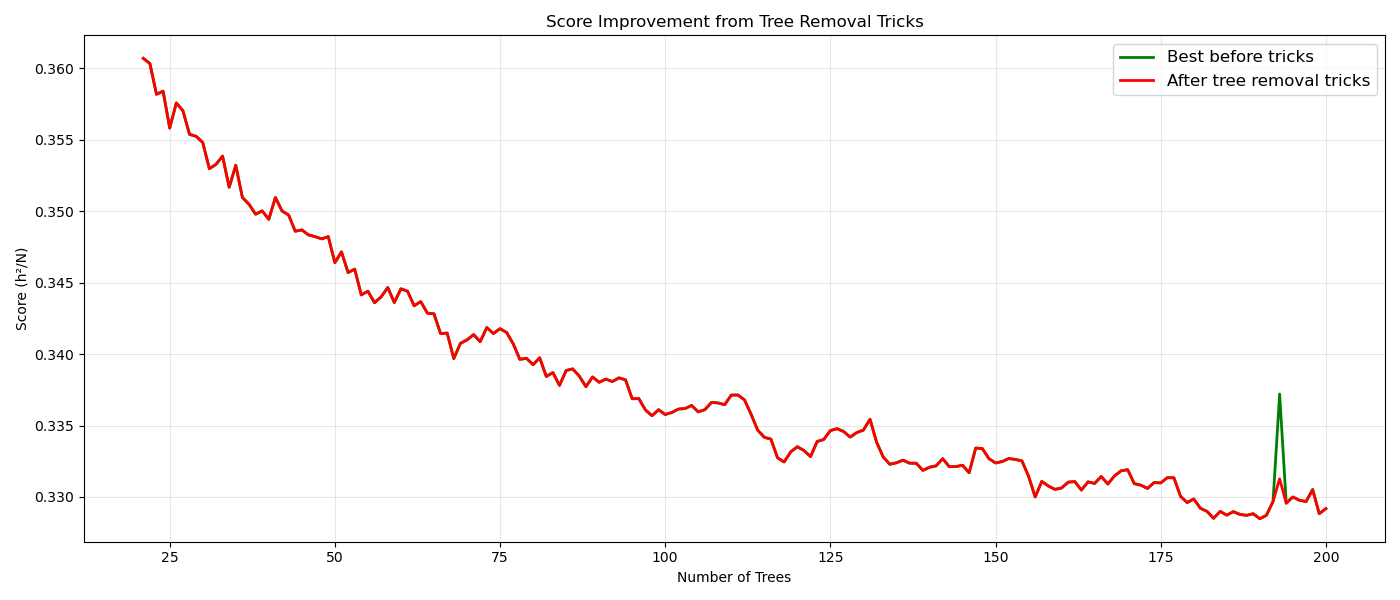

In [25]:
# take the best solution between mine and theirs and create a combined best (use a copy)
# Store initial scores before applying tricks
initial_scores = []
for i in range(len(N_trees)):
    if mine[1][i] <= theirs[1][i]:
        initial_scores.append(mine[1][i])
    else:
        initial_scores.append(theirs[1][i])

combined_best = [None] * 200
combined_scores = [None] * 200

# Work backwards from the last N to allow solutions to propagate backwards
for i in range(199, -1, -1):
    n = N_trees[i]
    
    if mine[1][i] <= theirs[1][i]:
        # Mine is better or equal
        best_sol = copy.deepcopy(mine[0][i])
        best_score = mine[1][i]
    else:
        # Theirs is better
        best_sol = copy.deepcopy(theirs[0][i])
        best_score = theirs[1][i]
    
    # Try removing a tree from N+1 solution if available
    if i + 1 < len(N_trees) and combined_best[i+1] is not None:
        next_sol = combined_best[i+1]
        
        # Try removing each tree from N+1 and calculate the new score
        for tree_idx in range(next_sol.N_trees):
            # Create a copy and remove the tree
            test_sol = copy.deepcopy(next_sol)
            
            # Remove the tree by slicing
            test_sol.xyt = cp.concatenate([
                test_sol.xyt[:, :tree_idx, :],
                test_sol.xyt[:, tree_idx+1:, :]
            ], axis=1)
            
            # Calculate the new score
            # Score is h^2 / N_trees
            test_score = (test_sol.h[0, 0]**2 / test_sol.N_trees).get()
            
            # If this is better, use it
            if test_score < best_score:
                best_sol = test_sol
                best_score = test_score
    
    combined_best[i] = best_sol
    combined_scores[i] = best_score

combined = (combined_best, combined_scores)

# Save the combined best solution
import pack_io
pdx = pack_io.solution_list_to_dataframe(combined_best, compact=False)
pdx.to_csv(kgs.temp_dir + 'submission.csv', index=False)

print(f"Combined total score: {np.sum(combined_scores):.6f}")
print(f"Mine total score: {np.sum(mine[1]):.6f}")
print(f"Theirs total score: {np.sum(theirs[1]):.6f}")
print(f"Initial best total score: {np.sum(initial_scores):.6f}")
print(f"Improvement: {np.sum(initial_scores) - np.sum(combined_scores):.6f}")

# Plot before and after
N=20
plt.figure(figsize=(14, 6))
plt.plot(N_trees[N:], initial_scores[N:], 'g-', label='Best before tricks', linewidth=2)
plt.plot(N_trees[N:], combined_scores[N:], 'r-', label='After tree removal tricks', linewidth=2)
plt.grid(True, alpha=0.3)
plt.xlabel('Number of Trees')
plt.ylabel('Score (h²/N)')
plt.title('Score Improvement from Tree Removal Tricks')
plt.legend(fontsize=12)
plt.tight_layout()


In [15]:
import pack_io
pd = pack_io.solution_list_to_dataframe(combined_best, compact=True)
pd.to_csv(kgs.temp_dir + 'submission_compact.csv', index=False)

Score of generated dataframe: 68.82587678813567


In [23]:
del pd
import pandas as pd
res = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.temp_dir + 'submission_compact.csv'))
np.sum(res[1])

np.float64(68.8258767881357)

In [ ]:
for ii in np.arange(0,181,20):
    print(ii, np.sum(mine[1][ii:ii+20]))

In [14]:
np.sum(np.array(combined_scores[83::2])),np.sum(np.array(combined_scores[82::2])),np.sum(np.array(combined_scores[83::2]))-np.sum(np.array(combined_scores[82::2]))

(np.float64(19.6462556892258),
 np.float32(19.65181),
 np.float64(-0.005554003157012488))